In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np

from utils import CSV_DAILY_INTENSITIES, CSV_DAILY_STEPS, CSV_DAILY_CALORIES

# Data Wrangling

In [ ]:
# Preview datasets
daily_intensites = pd.read_csv(CSV_DAILY_INTENSITIES)
daily_steps = pd.read_csv(CSV_DAILY_STEPS) #Daily Steps over 31 days of 33 users
daily_calories = pd.read_csv(CSV_DAILY_CALORIES) #Daily Calories over 31 days of 33 users
'''
print(daily_intensites)
print(daily_steps)
print(daily_calories)
'''

# Describe dataset
print(daily_intensites.describe())
print(daily_steps.describe())
print(daily_calories.describe())

# Cleaning dataset
users_in_daily_intensites = daily_intensites['Id'].nunique()
users_in_daily_steps = daily_steps['Id'].nunique()
users_in_daily_calories = daily_calories['Id'].nunique()

print("No of users in daily_intensites:", users_in_daily_intensites)
print("No of users in daily_steps:", users_in_daily_steps)
print("No of users in daily calories:", users_in_daily_calories)

# Find and remove duplicates 
print("Duplicates in daily_intensites:", daily_intensites.duplicated().sum())
print("Duplicates in daily_steps:", daily_steps.duplicated().sum())
print("Duplicates in daily claories:", daily_calories.duplicated().sum())

daily_intensites.drop_duplicates(inplace=True)
daily_steps.drop_duplicates(inplace=True)
daily_calories.drop_duplicates(inplace=True)

# Activity Intensity

<Figure size 1400x800 with 0 Axes>

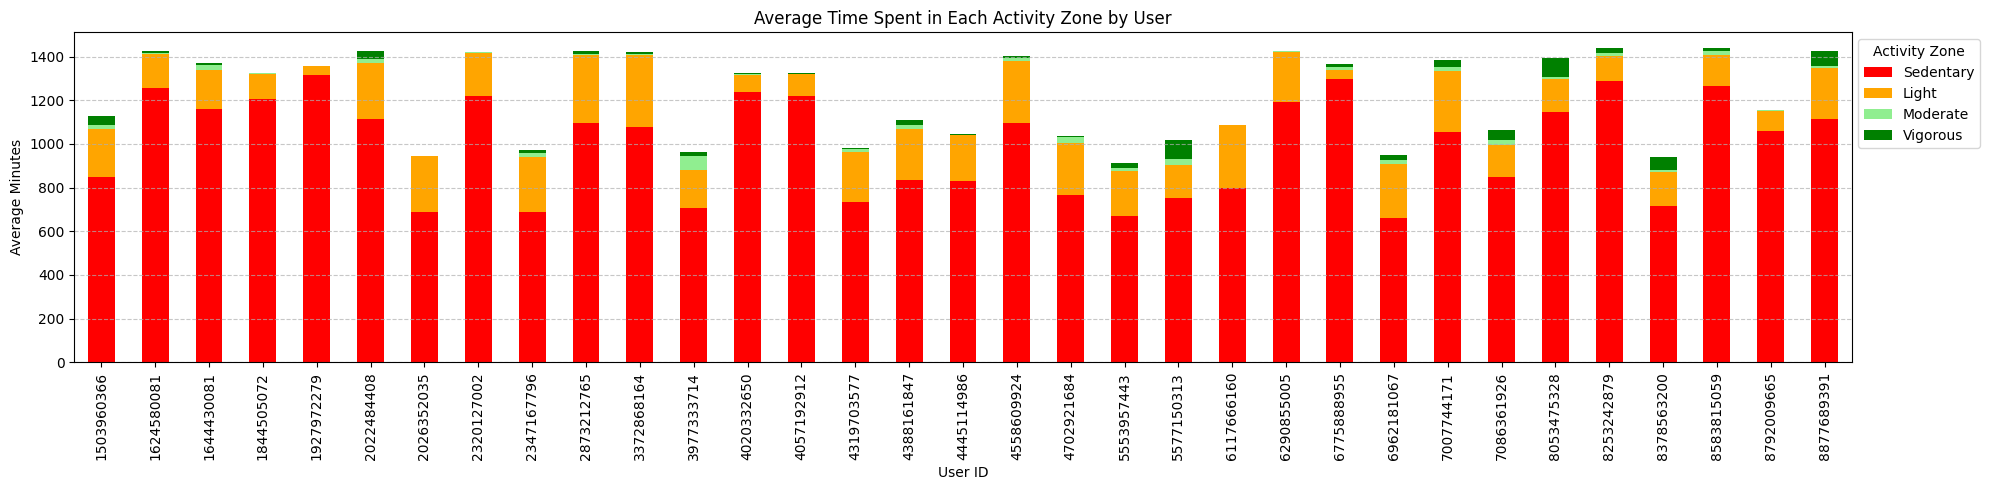

In [64]:
# Calculate average minutes per activity zone grouped by user.

average_minutes = daily_intensites.groupby("Id")[[
    'SedentaryMinutes', 'LightlyActiveMinutes', 'FairlyActiveMinutes', 'VeryActiveMinutes'
]].mean().rename(columns={
    'SedentaryMinutes': 'Sedentary',
    'LightlyActiveMinutes': 'Light',
    'FairlyActiveMinutes': 'Moderate',
    'VeryActiveMinutes': 'Vigorous'
})

# Define colors matching renamed labels
colors = ['red', 'orange', 'lightgreen', 'green']

# Plot
plt.figure(figsize=(14, 8))
average_minutes.plot(kind='bar', stacked=True, color=colors, figsize=(20, 5))

plt.title('Average Time Spent in Each Activity Zone by User')
plt.xlabel('User ID')
plt.ylabel('Average Minutes')
plt.legend(title='Activity Zone', bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

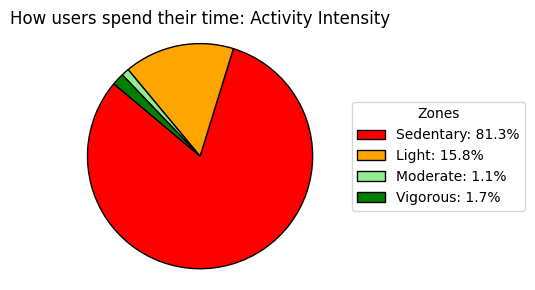

In [75]:
# PIE CHART of time spent in activity zone of the total device usage.

# Average time spent in each zone across all users
zone_time = {
    'Sedentary': daily_intensites['SedentaryMinutes'].mean(),
    'Light': daily_intensites['LightlyActiveMinutes'].mean(),
    'Moderate': daily_intensites['FairlyActiveMinutes'].mean(),
    'Vigorous': daily_intensites['VeryActiveMinutes'].mean()
}

# Convert to percentages
total_minutes = sum(zone_time.values())
zone_time_percentages = {k: (v / total_minutes) * 100 for k, v in zone_time.items()}

# Labels, values, and colors
labels = list(zone_time.keys())
sizes = list(zone_time.values())
colors = ['red', 'orange', 'lightgreen', 'green']

# Plotting the pie chart
fig, ax = plt.subplots(figsize=(5, 3))
wedges, texts = ax.pie(
    sizes,
    colors=colors,
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)

# Add legend with percentage labels
ax.legend(
    wedges,
    [f"{label}: {zone_time_percentages[label]:.1f}%" for label in labels],
    title="Zones",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.title("How users spend their time: Activity Intensity")
plt.axis('equal')
plt.tight_layout()
plt.show()


# Daily Steps

In [ ]:
daily_steps = pd.read_csv(CSV_DAILY_STEPS)

# Group data by user and calculate average daily steps

mean_steps_grouped = daily_steps.groupby("Id")['StepTotal'].mean().round().astype(int).reset_index()
mean_steps_grouped.rename(columns={'StepTotal': 'AverageDailySteps'}, inplace=True)
# print(mean_steps_grouped)

# Categorizing steps into levels intensity acc. to CDC Guidelines (References No. 2)
def categorize_steps(steps):
    if steps < 5000:
        return 'Sedentary'
    elif steps < 7500:
        return 'Light'
    elif steps < 10000:
        return 'Moderate'
    else:
        return 'Vigorous'

mean_steps_grouped['Intensity'] = mean_steps_grouped['AverageDailySteps'].apply(categorize_steps)
# print(mean_steps_grouped)

In [ ]:
# Bar plot gradient of steps per user 
# TO DO Scale fill gradient on bars 

colors = {
    "Sedentary": "red",
    "Light": "orange",
    "Moderate": "lightgreen",
    "Vigorous": "green"
}

mean_steps_grouped['Color'] = mean_steps_grouped['Intensity'].map(colors)

plt.figure(figsize=(12, 6))
bars = plt.bar(
    mean_steps_grouped['Id'].astype(str),
    mean_steps_grouped['AverageDailySteps'],
    color=mean_steps_grouped['Color']
)

plt.xlabel("User ID")
plt.ylabel("Average Daily Steps")
plt.title("Average Daily Steps per User Categorized by Intensity")
plt.xticks(rotation=90)

# Add legend manually
legend_labels = list(colors.keys())
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in legend_labels]
plt.legend(legend_handles, legend_labels, title="Intensity Level")

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Average daily steps, intensity and step goal

In [ ]:

# Create a dictionary where keys are intensity levels and values are lists of user IDs
users_by_intensity = mean_steps_grouped.groupby('Intensity')['Id'].apply(list).to_dict()

# Print the list of users in activity zone
for category, users in users_by_intensity.items():
    print(f"{category} ({len(users)} users): {users}")


In [ ]:
# Recommendation
# Define a function to assign step goals
def recommend_step_goal(intensity):
    if intensity == 'Sedentary':
        return 7500
    elif intensity == 'Light':
        return 10000
    elif intensity == 'Moderate':
        return 12000
    elif intensity == 'Vigorous':
        return 12000  # For maintaining or improving
    else:
        return None
    
# Apply the function to the dataframe
mean_steps_grouped['RecommendedStepGoal'] = mean_steps_grouped['Intensity'].apply(recommend_step_goal)

# Print recommended step goal.
print("CDC recommends an average of 7500 steps per day for healthy living.\nRefer to Article 2 for more information.")
print(mean_steps_grouped[['Id', 'AverageDailySteps', 'Intensity', 'RecommendedStepGoal']])

# What is the effect of intensity duration on the average calorie expenditure?

In [ ]:
# Average time spent in each zone per user
daily_intensites_duration = daily_intensites.groupby("Id").agg({
    'SedentaryMinutes': 'mean',
    'LightlyActiveMinutes': 'mean',
    'FairlyActiveMinutes': 'mean',
    'VeryActiveMinutes': 'mean',
}).reset_index()

# print(daily_intensites_duration)

# Average calorie expenditure per user
mean_calories_grouped = daily_calories.groupby("Id")['Calories'].mean().round().astype(int).reset_index()
mean_calories_grouped.rename(columns={'Calories': 'AverageCalories'}, inplace=True)

# print(mean_calories_grouped)

#Merge the Two DataFrames
merged_duration_calories = pd.merge(daily_intensites_duration, mean_calories_grouped, on='Id')

print(merged_duration_calories)

In [ ]:
'''
One Way ANOVA - if the calorie expenditure changes acc. to the duration in intensity category (HYPOTHESIS TESTING)
1. Categorical independent variable = Average time spent in each zone per user
2. Quantiative dependent variable = Average calorie expenditure
'''

In [ ]:
''' 
Multiple Linear Regression - To analyze the influence of each activity zone on calories
1. Independent variable = daily_intensites_duration
2. dependet variable = mean_calories_grouped
'''
# Compute correlation matrix
corr = merged_duration_calories.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Duration of Intensity vs. Calorie Expenditure")
plt.tight_layout()
plt.show()


In [ ]:

# Set plot size
plt.figure(figsize=(10, 6))

# Plot scatter for each activity zone
plt.scatter(merged_duration_calories['SedentaryMinutes'], merged_duration_calories['AverageCalories'], label='Sedentary', color='red', alpha=0.6)
plt.scatter(merged_duration_calories['LightlyActiveMinutes'], merged_duration_calories['AverageCalories'], label='Lightly Active', color='orange', alpha=0.6)
plt.scatter(merged_duration_calories['FairlyActiveMinutes'], merged_duration_calories['AverageCalories'], label='Moderately Active', color='lightgreen', alpha=0.6)
plt.scatter(merged_duration_calories['VeryActiveMinutes'], merged_duration_calories['AverageCalories'], label='Vigorous', color='green', alpha=0.6)

# Labels and title
plt.xlabel("Average Minutes per Activity Zone")
plt.ylabel("Average Calories Burned")
plt.title("Relationship Between Activity Duration and Calorie Burn (per User)")
plt.legend(title="Activity Intensity")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Relationship Between Activity Duration and Calorie Burn (per User)", fontsize=16)

zones = [
    ('SedentaryMinutes', 'SEDENTARY', 'red'),
    ('LightlyActiveMinutes', 'LIGHT', 'orange'),
    ('FairlyActiveMinutes', 'MODERATE', 'lightgreen'),
    ('VeryActiveMinutes', 'VIGOROUS', 'green')
]

for ax, (col, label, color) in zip(axs.flatten(), zones):
    x = merged_duration_calories[col]
    y = merged_duration_calories['AverageCalories']
    
    ax.scatter(x, y, color=color, alpha=0.6)
    
    # Fit linear regression
    coeffs = np.polyfit(x, y, deg=1)
    poly_eq = np.poly1d(coeffs)
    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = poly_eq(x_fit)
    
    ax.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=1)
    
    ax.set_xlabel("Average Minutes")
    ax.set_ylabel("Average Calories")
    ax.set_title(label)
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave room for the suptitle
plt.show()
